In [ ]:
import time

from typing import Literal

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
csv_data = pd.read_csv('drive/MyDrive/FinancialSentimentAnalysis/data.csv')
csv_data.head(n=10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

In [ ]:
tokens = tokenizer(
    csv_data['Sentence'].tolist(),
    return_tensors='pt',
    padding=True,
    return_token_type_ids=False,
)

print(f"{tokens.keys() = }")

input_ids_shape = tokens['input_ids'].shape
print(f"{input_ids_shape = }")

max_seq_len = input_ids_shape[1]
print(f"{max_seq_len = }")

vocab_size = len(tokenizer.vocab)
print(f"{vocab_size = }")

tokens.keys() = dict_keys(['input_ids', 'attention_mask'])
input_ids_shape = torch.Size([5842, 150])
max_seq_len = 150
vocab_size = 30522


In [ ]:
categories = list(set(csv_data['Sentiment']))
labels = list(map(categories.index, csv_data['Sentiment']))

print(f"{categories = }")

categories = ['positive', 'neutral', 'negative']


## Dataset Visualization

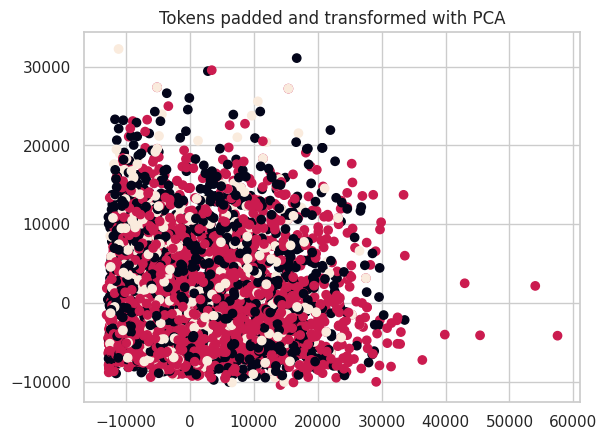

In [ ]:
pca = PCA(n_components=2)
data_transformed = pca.fit_transform(tokens['input_ids'])

plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=labels)
plt.title('Tokens padded and transformed with PCA')
plt.show()

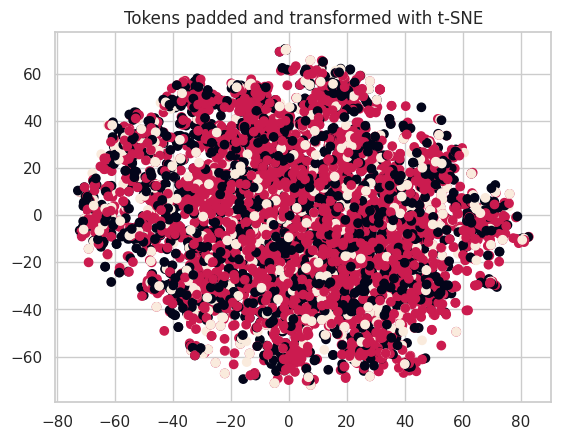

In [ ]:
tsne = TSNE(n_components=2)
data_transformed = tsne.fit_transform(tokens['input_ids'])
plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=labels)
plt.title('Tokens padded and transformed with t-SNE')
plt.show()

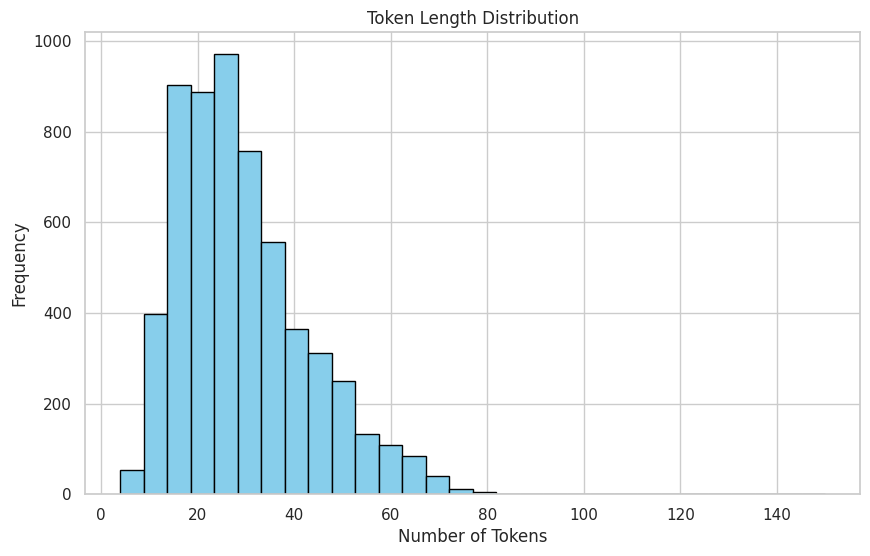

In [ ]:
token_lengths = [sum(attention_mask) for attention_mask in tokens['attention_mask']]

plt.figure(figsize=(10, 6))
plt.hist(token_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

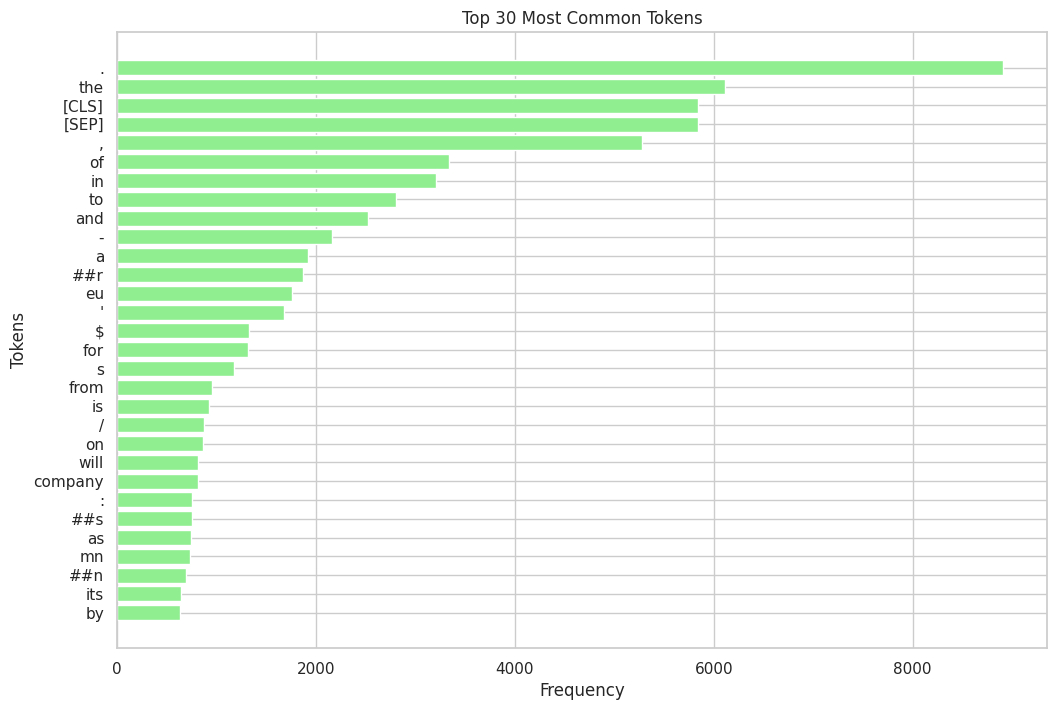

In [ ]:
from collections import Counter

# Flatten the list of input_ids
all_tokens = [token for input_id in tokens['input_ids'] for token in input_id.tolist()]

# Count the frequency of each token
token_counts = Counter(all_tokens)

# Get the most common tokens
most_common_tokens = token_counts.most_common(31)[1:]

# Plot the most common tokens
token_ids, counts = zip(*most_common_tokens)
token_strings = [tokenizer.decode([token_id]) for token_id in token_ids]

plt.figure(figsize=(12, 8))
plt.barh(token_strings, counts, color='lightgreen')
plt.title('Top 30 Most Common Tokens')
plt.xlabel('Frequency')
plt.ylabel('Tokens')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

In [ ]:
class FsaDataset(Dataset):
    def __init__(self, split: Literal['train', 'valid']):
        if split == 'train':
            split_slice = slice(0, int(len(tokens['input_ids']) * 0.8))
        else:
            split_slice = slice(
                int(len(tokens['input_ids']) * 0.8), len(tokens['input_ids'])
            )

        self.input_ids = tokens['input_ids'][split_slice]
        self.attention_mask = tokens['attention_mask'][split_slice]
        self.labels = labels[split_slice]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

train_ds = FsaDataset('train')
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

valid_ds = FsaDataset('valid')
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

## Plot data distributions

<ipython-input-9-a1e20dbaac34>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=train_df, x='label', palette='viridis', order=categories)
<ipython-input-9-a1e20dbaac34>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=valid_df, x='label', palette='viridis', order=categories)
<ipython-input-9-a1e20dbaac34>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-9-a1e20dbaac34>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

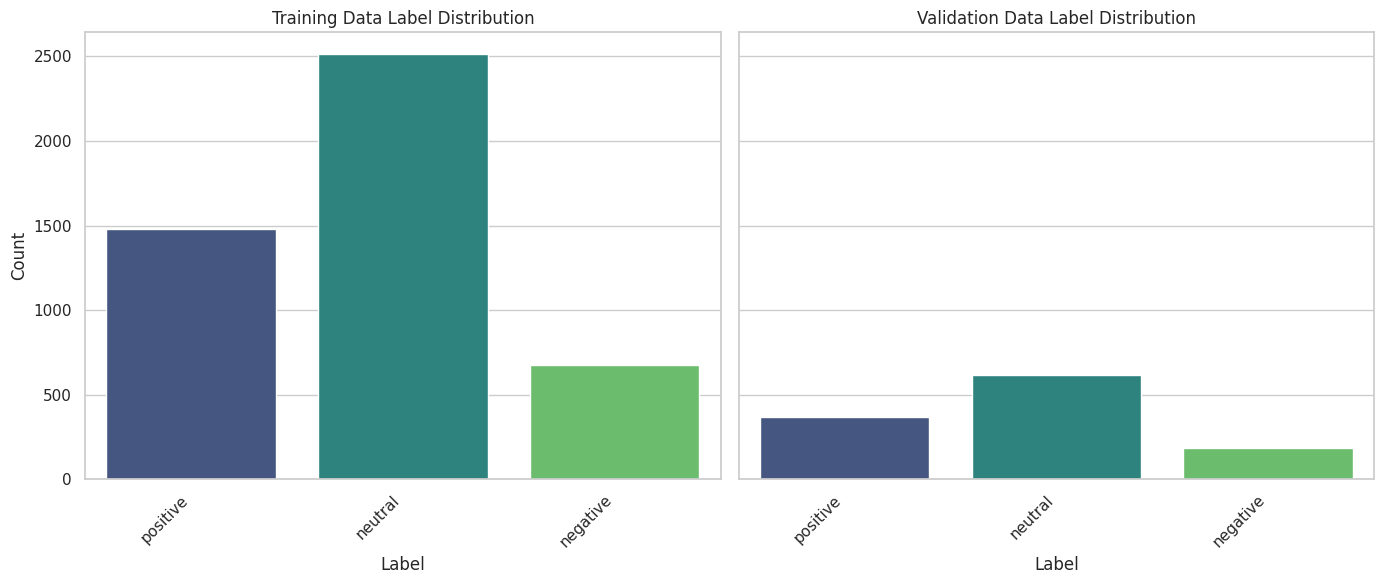

In [ ]:
train_labels = []
valid_labels = []

for _, _, labels in train_dl:
    train_labels.extend([categories[label] for label in labels.numpy()])

for _, _, labels in valid_dl:
    valid_labels.extend([categories[label] for label in labels.numpy()])

train_df = pd.DataFrame(train_labels, columns=['label'])
valid_df = pd.DataFrame(valid_labels, columns=['label'])

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.countplot(ax=axes[0], data=train_df, x='label', palette='viridis', order=categories)
axes[0].set_title('Training Data Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

sns.countplot(ax=axes[1], data=valid_df, x='label', palette='viridis', order=categories)
axes[1].set_title('Validation Data Label Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Definition of the models
### 3-layered Recurrent Neural Network

In [ ]:
class TextClassificationRNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int, num_layers: int = 3):
        super(TextClassificationRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_ids)

        lengths = attention_mask.sum(dim=1).cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_rnn_output, hidden = self.rnn(packed_embedded)
        rnn_output, _ = nn.utils.rnn.pad_packed_sequence(packed_rnn_output, batch_first=True)
        output = self.fc(hidden[-1])

        return output


def test_rnn():
    embedding_dim = 50
    hidden_dim = 100
    output_dim = 5
    num_layers = 3
    model = TextClassificationRNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
    sample_input = torch.randint(0, vocab_size, (4, 10))
    attention_mask = torch.ones(4, 10)
    output = model(sample_input, attention_mask)
    print(f"RNN output shape: {output.shape}")

test_rnn()

RNN output shape: torch.Size([4, 5])


### 3-layered Long Short-Term Memory

In [ ]:
class TextClassificationLSTM(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, output_dim: int, num_layers: int = 3):
        super(TextClassificationLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_ids)

        lengths = attention_mask.sum(dim=1).cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        output = self.fc(hidden)
        return output

def test_lstm():
    vocab_size = 10000
    embedding_dim = 50
    hidden_dim = 100
    output_dim = 5
    num_layers = 3
    model = TextClassificationLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers)
    sample_input = torch.randint(0, vocab_size, (4, 10))
    attention_mask = torch.ones(4, 10)
    output = model(sample_input, attention_mask)
    print(f"LSTM output shape: {output.shape}")

test_lstm()

LSTM output shape: torch.Size([4, 5])


### 3-layered Transformer

In [ ]:
class TextClassificationTransformer(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, output_dim: int, num_heads: int, num_layers: int, max_seq_len: int):
        super(TextClassificationTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor):
        seq_len = input_ids.size(1)
        position_ids = torch.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(input_ids.size(0), seq_len)
        embedded = self.embedding(input_ids) + self.position_embedding(position_ids)
        transformer_output = self.transformer_encoder(embedded, src_key_padding_mask=attention_mask == 0)
        cls_representation = transformer_output[:, 0, :]
        output = self.fc(cls_representation)
        return output

def test_transformer():
    vocab_size = 10000
    embedding_dim = 56
    output_dim = 5
    num_heads = 8
    num_layers = 3
    max_seq_len = 512
    model = TextClassificationTransformer(vocab_size, embedding_dim, output_dim, num_heads, num_layers, max_seq_len)
    sample_input = torch.randint(0, vocab_size, (4, 10))
    attention_mask = torch.ones(4, 10)
    output = model(sample_input, attention_mask)
    print(f"Transformer output shape: {output.shape}")

test_transformer()

Transformer output shape: torch.Size([4, 5])


In [ ]:
def train_step(
    model: nn.Module, train_dl: DataLoader, optimizer: optim.Optimizer, criterion: nn.Module, device: torch.device
):
    model.train()
    losses = []
    for input_ids, attention_mask, labels in train_dl:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)

        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return losses


def valid_step(
    model: nn.Module, valid_dl: DataLoader, criterion: nn.Module, device: torch.device
):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in valid_dl:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    report = classification_report(
        all_labels, all_preds, target_names=categories, output_dict=True, zero_division=0,
    )
    return report

def train_model(
    model: nn.Module, train_dl: DataLoader, valid_dl: DataLoader, num_epochs: int, learning_rate: float, device: torch.device
):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)

    train_losses = []
    reports = []

    for epoch in range(num_epochs):
        print(f"===== Epoch {epoch + 1}/{num_epochs} =====")

        train_loss = train_step(model, train_dl, optimizer, criterion, device)
        train_losses.extend(train_loss)
        if (epoch + 1) % 5 == 0:
            print(f"Train Loss: {sum(train_loss) / len(train_dl)}")

        report = valid_step(model, valid_dl, criterion, device)
        if (epoch + 1) % 5 == 0:
            print(f"Validation Metrics:\n{report}")
        reports.append(report)

    return train_losses, reports

In [ ]:
def plot_train_details(train_losses, reports):
    steps = range(1, len(train_losses) + 1)
    epochs = range(1, len(reports) + 1)

    plt.figure(figsize=(14, 6))

    plt.plot(steps, train_losses, 'bo-', label='Training Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss over Steps')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 6))

    for idx, category in enumerate(categories, start=1):
        precisions = []
        recalls = []
        f1_scores = []
        for report in reports:
            precisions.append(report[category]['precision'])
            recalls.append(report[category]['recall'])
            f1_scores.append(report[category]['f1-score'])

        plt.subplot(1, len(categories), idx)
        plt.plot(epochs, precisions, label=f'Precision')
        plt.plot(epochs, recalls, label=f'Recall')
        plt.plot(epochs, f1_scores, label=f'F1-Score')

        plt.xlabel('Epochs')
        plt.ylabel('Score')
        plt.title(f'Validation Metrics for "{category}"')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(14, 6))
    plt.plot(epochs, [report['accuracy'] for report in reports], label=f'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Training the models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_layers = 3
embedding_dim = 128
hidden_dim = 256
output_dim = len(categories)

num_epochs = 200
learning_rate = 1e-5

print(f"{device = }")
print(f"{num_layers = }")
print(f"{embedding_dim = }")
print(f"{hidden_dim = }")
print(f"{output_dim = }")

print(f"{num_epochs = }")
print(f"{learning_rate = }")

device = device(type='cpu')
num_layers = 3
embedding_dim = 128
hidden_dim = 256
output_dim = 3
num_epochs = 200
learning_rate = 1e-05


In [ ]:
rnn_model = TextClassificationRNN(
    vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers
)
rnn_num_parameters = sum(param.numel() for param in rnn_model.parameters())
print(f"{rnn_num_parameters = }")

start_time = time.time()
rnn_train_losses, rnn_reports = train_model(
    rnn_model, train_dl, valid_dl, num_epochs=num_epochs, learning_rate=learning_rate, device=device
)
exec_time = time.time() - start_time
print(f"RNN execution time: {exec_time}")

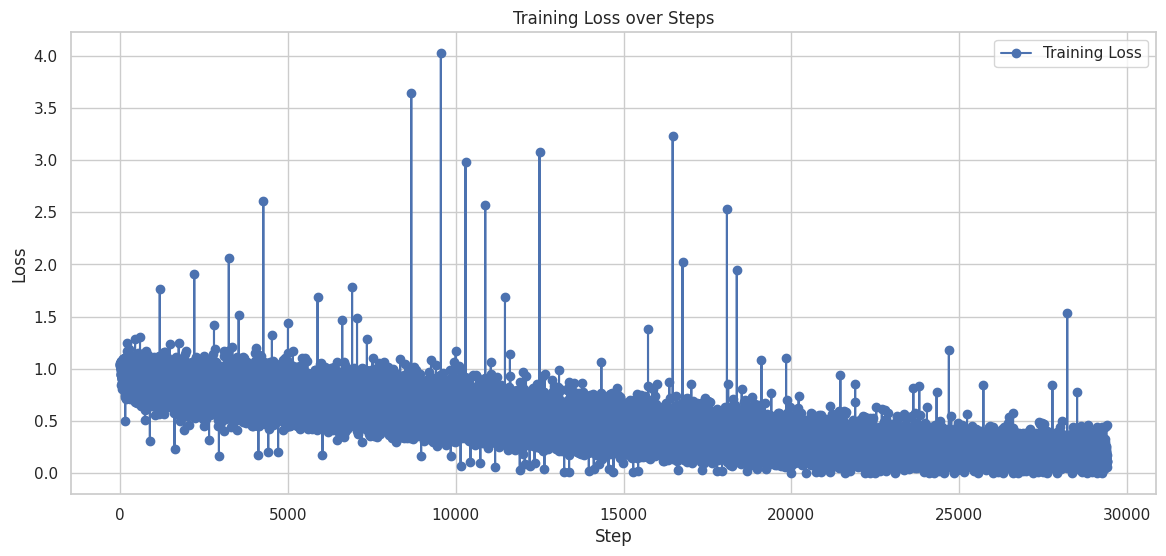

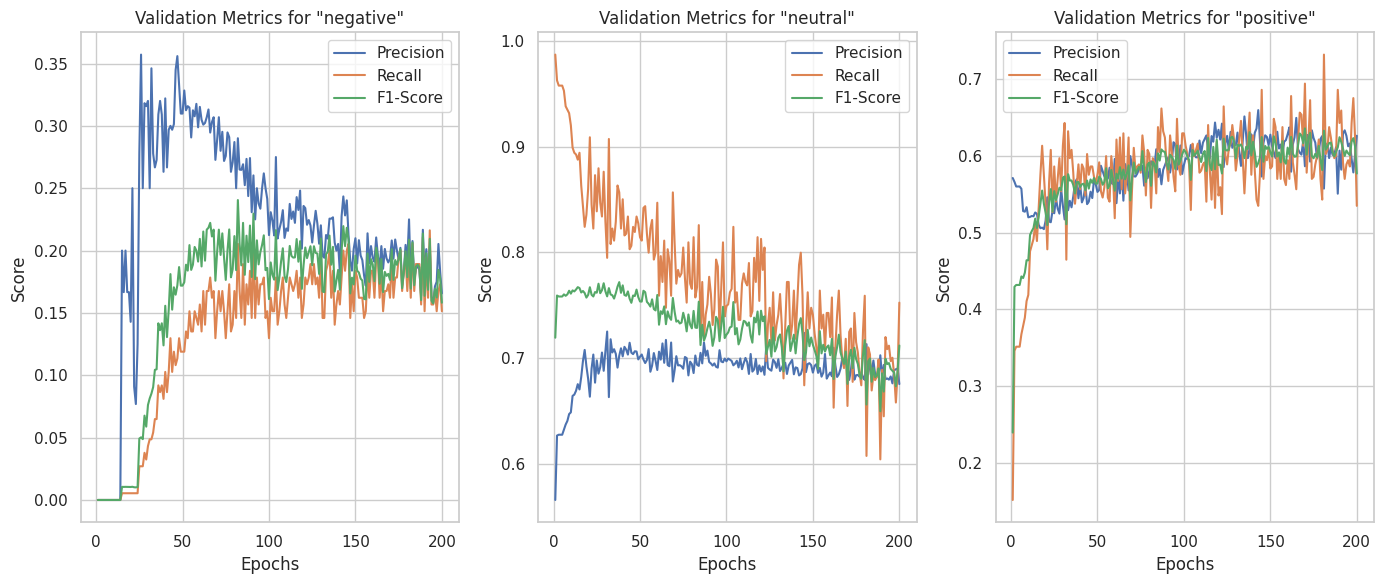

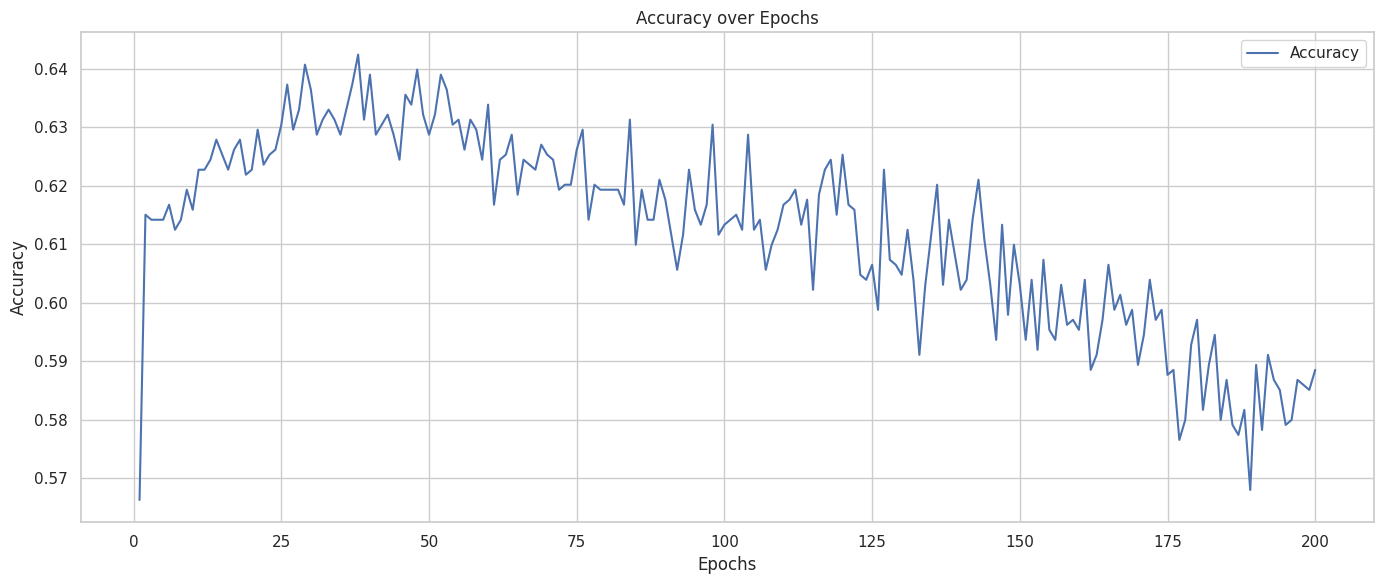

In [ ]:
plot_train_details(rnn_train_losses, rnn_reports)

In [ ]:
lstm_model = TextClassificationLSTM(
    vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers
)
lstm_num_parameters = sum(param.numel() for param in lstm_model.parameters())
print(f"{lstm_num_parameters = }")
start_time = time.time()
lstm_train_losses, lstm_reports = train_model(
    lstm_model, train_dl, valid_dl, num_epochs=num_epochs, learning_rate=learning_rate, device=device
)
exec_time = time.time() - start_time
print(f"LSTM execution time: {exec_time}")

LSTM execution time: 419.0696406364441


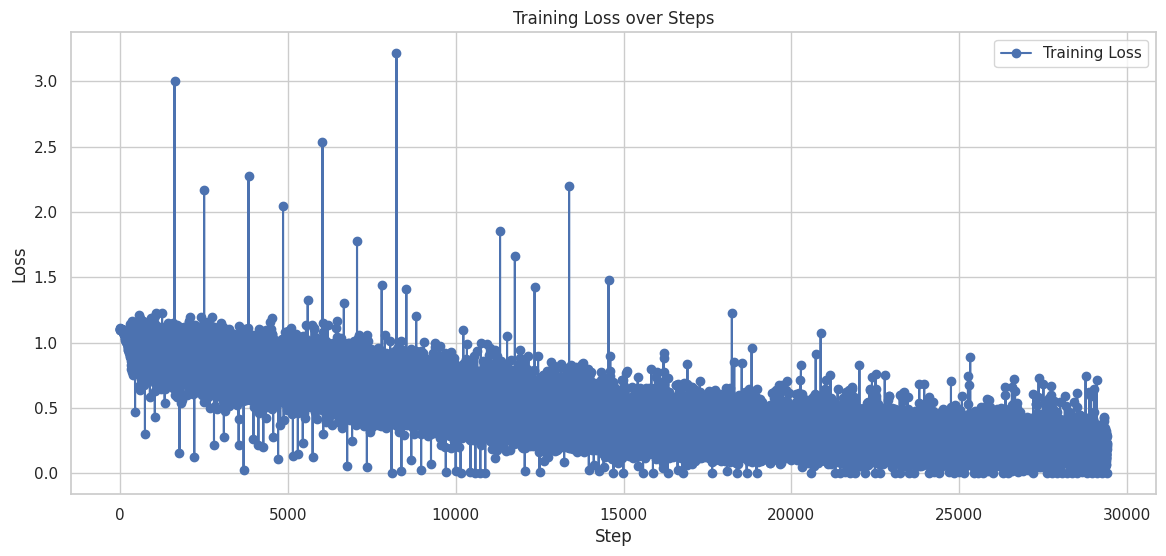

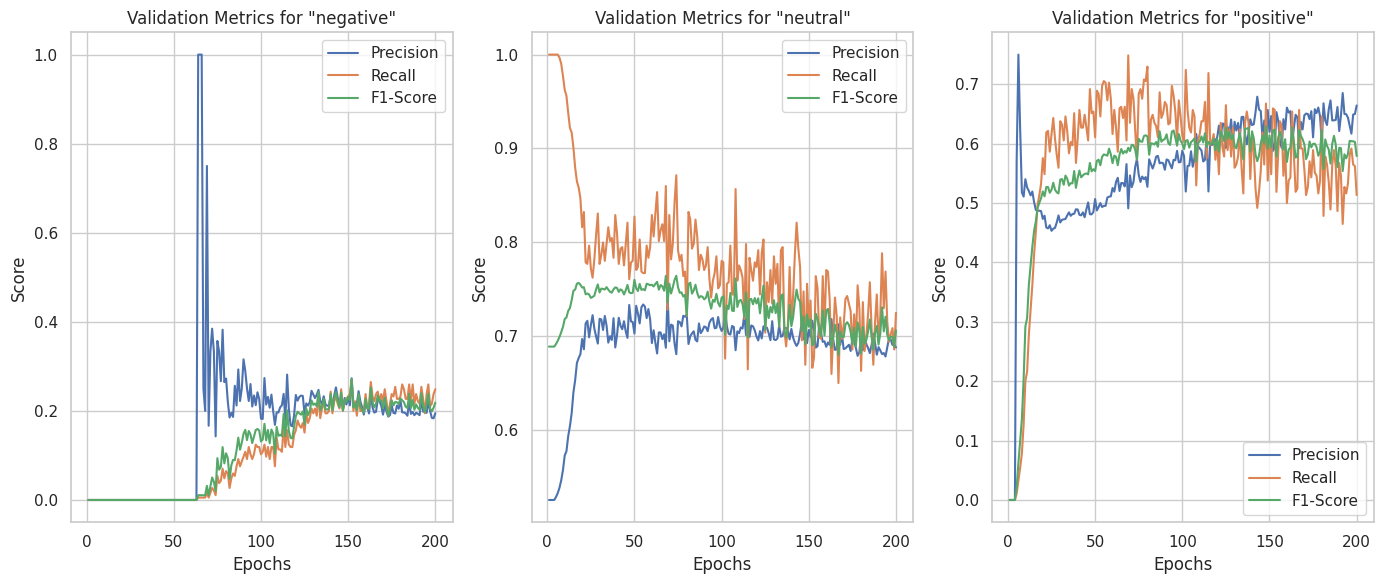

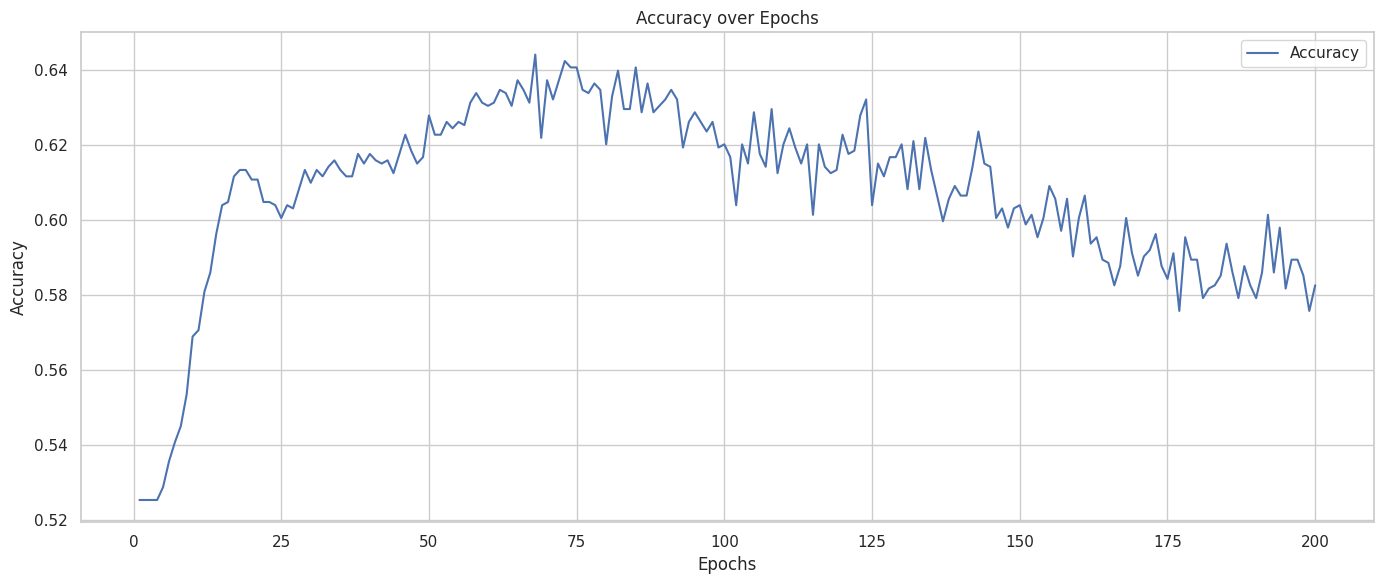

In [ ]:
print(f"LSTM execution time: {exec_time}")
plot_train_details(lstm_train_losses, lstm_reports)

In [ ]:
num_heads = 8
transformer_model = TextClassificationTransformer(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    max_seq_len=max_seq_len,
)
transformer_num_parameters = sum(param.numel() for param in transformer_model.parameters())
print(f"{transformer_num_parameters = }")

start_time = time.time()
transformer_train_losses, transformer_reports = train_model(
    transformer_model, train_dl, valid_dl, num_epochs=num_epochs, learning_rate=learning_rate, device=device
)
exec_time = time.time() - start_time
print(f"Transformer execution time: {exec_time}")

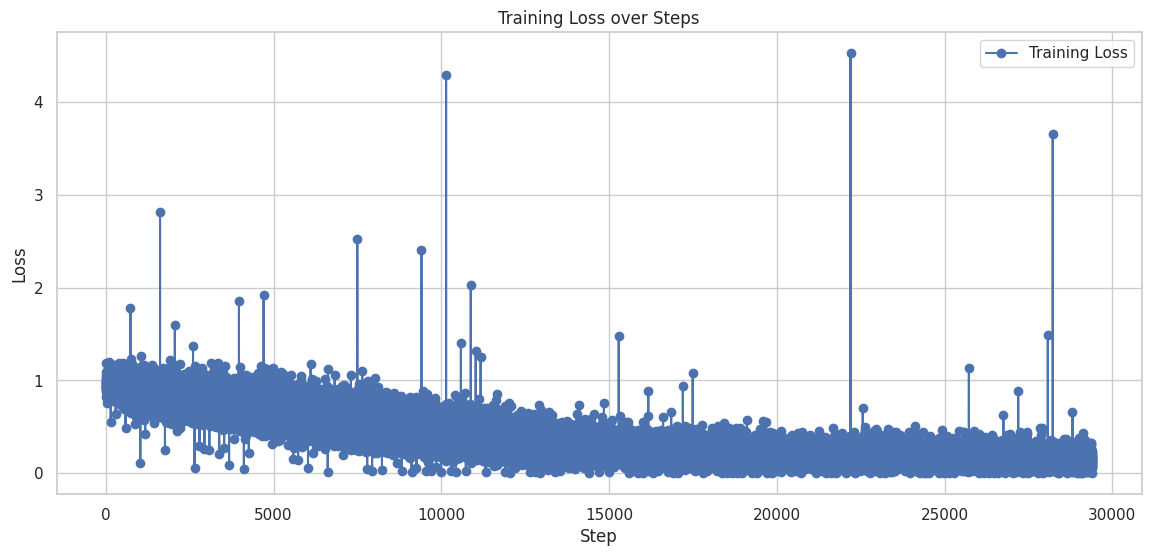

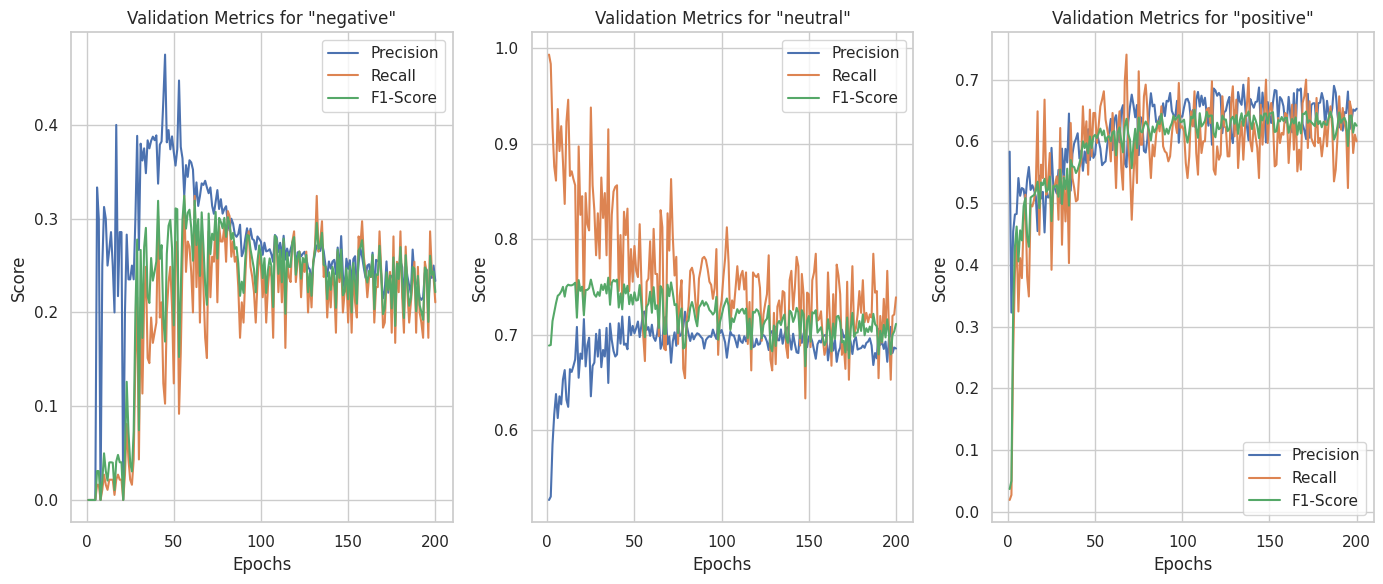

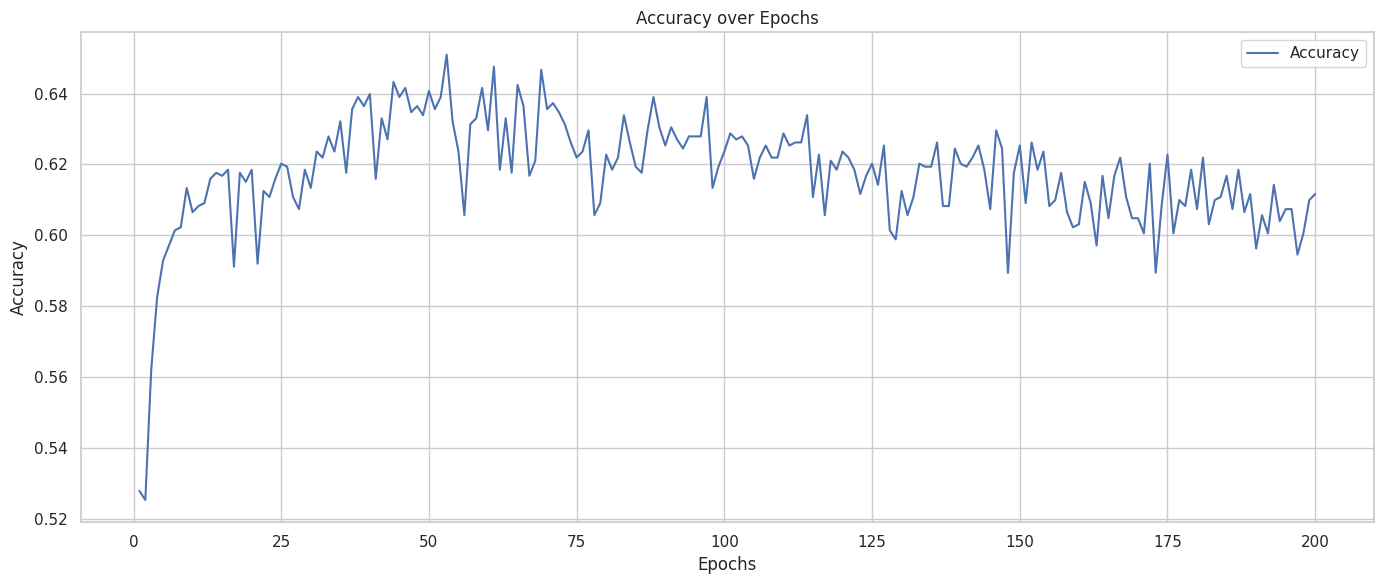

In [ ]:
plot_train_details(transformer_train_losses, transformer_reports)